In [40]:
%load_ext autoreload
%autoreload 2

from pandas import read_excel
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import timeit
import pickle

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn import tree    #https://scikit-learn.org/stable/modules/svm.html
                                 #https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

from modAL.models import ActiveLearner             #https://modal-python.readthedocs.io/en/latest/content/models/ActiveLearner.html
from modAL.uncertainty import entropy_sampling     #https://modal-python.readthedocs.io/en/latest/content/apireference/uncertainty.html
from modAL.disagreement import vote_entropy_sampling
from modAL.multilabel import SVM_binary_minimum

import sys
sys.path.insert(0, '/home/jovyan/Thesis_ActLearn_DOP_2022/main/active_learning/')
import functions as fun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Loading data sets
full_data_BatchA = pd.read_csv('/home/jovyan/Thesis_ActLearn_DOP_2022/main/active_learning/data/full_data_BatchA.csv')
y = full_data_BatchA['Label'].to_numpy()
X_morgan = full_data_BatchA.drop(['Label'], axis = 1).to_numpy()

In [41]:
# Only default values exept random state for replications
# NOTE: SVM can be use only if the model is a SVM classifier
svm_clf1 = SVC(random_state = 0, probability=True)

In [19]:
# Parameters for ML model
train_size = 0.01
test_size = 0.3

# split dataset into train(- %), test(- %), unlabel(- %)
x_train, y_train, x_test, y_test, x_pool, y_pool = fun.split(x_dataset = X_morgan, y_dataset = y, 
                                                             ini_train_size = train_size, test_size = test_size)

In [20]:
print(f'The inicial training set has size {len(x_train)}')
print(f'The inicial pool set has size {len(x_pool)}')
print(f'The inicial test set has size {len(x_test)}')

The inicial training set has size 36
The inicial pool set has size 3583
The inicial test set has size 1552


In [42]:
# Parameters for AL
N_QUERIES = 200#int(2*len(x_pool)/3)

#Timer
tic=timeit.default_timer()

performance_history = []
cf_matrix_history = []

svm_clf1.fit(x_train,y_train)
learner = ActiveLearner(estimator=svm_clf1, query_strategy = SVM_binary_minimum, X_training = x_train, y_training = y_train)

#Making predictions
y_pred = learner.predict(x_test)


#Calculate and report our model's accuracy.
model_accuracy = learner.score(x_test, y_test)

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Save our model's performance for plotting.
performance_history.append(model_accuracy)
cf_matrix_history.append(cf_matrix)

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):

    #Query for a new point
    query_index, query_instance = learner.query(x_pool)

    # Teach our ActiveLearner model the record it has requested.
    XX, yy = x_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
    learner.teach(X=XX, y=yy)

    # Remove the queried instance from the unlabeled pool.
    x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)

    y_pred = learner.predict(x_test)
    model_accuracy = learner.score(x_test, y_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    #print(cf_matrix)
    performance_history.append(model_accuracy)
    cf_matrix_history.append(cf_matrix)


    if index % 100 == 0:
        print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))



toc=timeit.default_timer()
print(f'\n\nElapsed time: {toc-tic} seconds')

AttributeError: 'SVC' object has no attribute 'estimators_'

In [32]:
svm.SVC().decision_function


<bound method BaseSVC.decision_function of SVC()>

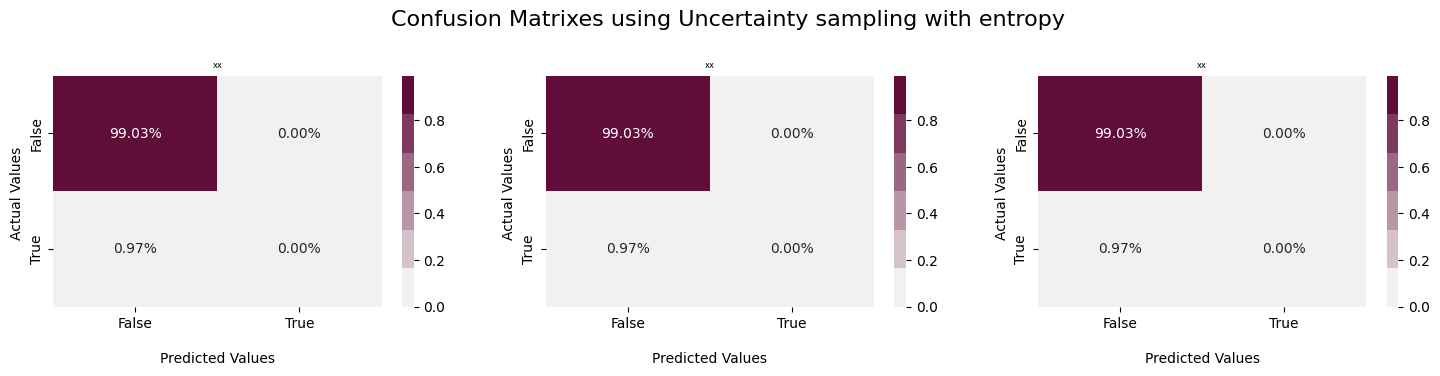

In [30]:
#Plot
fig, axes = plt.subplots(1, 3, figsize=(18,3))
i = 0
for row in axes:
    fun.plot_cf_mat(matrix = cf_matrix_history[-1], sub_title = 'xx' ,save = False, figure_name = None, ax=row)
    i+=1
fig.suptitle('Confusion Matrixes using Uncertainty sampling with entropy\n', fontsize=16, y =1.1)
plt.show()